# Univariate ROI Analysis

In [1]:
%matplotlib inline

In [2]:
import os
import os.path as op

import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import moss
import lyman

In [3]:
os.environ["LYMAN_DIR"] = op.abspath("../lyman")
analysis_dir = lyman.gather_project_info()["analysis_dir"]
os.environ["SUBJECTS_DIR"]  = lyman.gather_project_info()["data_dir"]

In [4]:
from punch_utils import SurfacePlotter, estimate_roi_firs, extract_cope_data, groupby_ttest

In [5]:
sns.set(style="ticks", context="paper",
        rc={"xtick.major.size": 3, "ytick.major.size": 3,
            "xtick.major.width": 1, "ytick.major.width": 1,
            "xtick.major.pad": 3.5, "ytick.major.pad": 3.5,
            "axes.linewidth": 1, "lines.linewidth": 1})
mpl.rcParams["savefig.dpi"] = 150
pd.set_option("precision", 3)

In [6]:
subjects = pd.Series(np.loadtxt("subjects.txt", str), name="subj")

In [7]:
networks = dict(lat=["IFS", "IPS"], med=["mSPL", "PCC"])
network_map = dict(ifs="lat", ips="lat", mspl="med", pcc="med")

In [8]:
pal_kws = dict(start=0, light=.7, dark=.2)
palettes = dict(lat=sns.cubehelix_palette(4, rot=.2, **pal_kws),
                med=sns.cubehelix_palette(4, rot=-.2, **pal_kws))
purple = "#6c4d87"
blue = "#476087"
brown = "#a6805f"
red = "#874858"

In [9]:
punch_data = pd.read_csv("data/punch_data.csv")
cpe = punch_data["pe_context"]
cpe_z = stats.zscore((cpe - .5))
cpe_range = np.percentile(cpe_z, 95) - np.percentile(cpe_z, 5)

In [10]:
def savefig(fig, name):
    fig.savefig("figures/{}.pdf".format(name), dpi=120)
    fig.savefig("figures/{}.png".format(name), dpi=120)
    fig.savefig("tiffs/{}.tiff".format(name), dpi=300)

---

This notebook assumes that the ROI timecourse data has been cached. That can be accomplished with the following code

    rois = ['yeo17_ifs', 'yeo17_ips', 'yeo17_mspl', 'yeo17_pcc']
    import punch_utils
    punch_utils.cache_roi_timecourses(rois)

----

## Test effect of CPE from main model

In [11]:
rois = ["IFS", "IPS", "mSPL", "PCC"]
masks = ["yeo17_" + r.lower() for r in rois]
cpe_main_coefs = extract_cope_data(masks, "cpe_main", ["task", "cpe"])
cpe_main_coefs.to_csv("data/cpe_main_coefs.csv", index=False)

In [12]:
groupby_ttest(cpe_main_coefs.query("param == 'cpe'"), "cope", "roi").astype(object)

,mean,t,p
roi,,,
yeo17_ifs,6.73,6.16,2.46e-05
yeo17_ips,9.2,5.93,3.66e-05
yeo17_mspl,8.32,5.47,8.2e-05
yeo17_pcc,6.65,5.29,0.000115


In [13]:
(cpe_main_coefs.set_index(["subj", "roi", "param"])
               .loc[:, "cope"]
               .unstack()
               .eval("(cpe * @cpe_range) / task")
               .groupby(level="roi")
               .describe()
               .unstack()
               .loc[:, ["mean", "std"]])

,mean,std
roi,,
yeo17_ifs,0.47,0.43
yeo17_ips,0.24,0.33
yeo17_mspl,1.21,1.53
yeo17_pcc,0.66,0.75


----

## Test effect of CPE during cue period

In [14]:
cpe_cuestim_coefs = extract_cope_data(masks, "cpe_cuestim", ["cue", "cpe_cue"])
cpe_cuestim_coefs.to_csv("data/cpe_cuestim_coefs.csv", index=False)

In [15]:
groupby_ttest(cpe_cuestim_coefs, "cope", ["roi", "param"]).astype(object)

mean     t         p
roi        param                        
yeo17_ifs  cpe_cue  8.84  3.01   0.00935
           cue      36.6   5.9   3.9e-05
yeo17_ips  cpe_cue  14.9  3.99   0.00134
           cue      54.3  6.25  2.12e-05
yeo17_mspl cpe_cue  8.43  2.53    0.0238
           cue      16.8  2.28    0.0389
yeo17_pcc  cpe_cue  7.18  2.46    0.0276
           cue      22.1  4.79  0.000287

----

## Plot CPE quartiles

In [16]:
cortex = SurfacePlotter("cpe_main", "cpe", show_mask=False)
cortex.add_rois(["yeo17_ifs", "yeo17_ips", "yeo17_mspl", "yeo17_pcc"],
                [purple, purple, blue, blue])
cortex.save_views(["lat", "med"])
cortex.close()

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/traits/has_traits.py:1766: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


In [17]:
rois = ["IFS", "IPS", "mSPL", "PCC"]
masks = ["yeo17_" + r.lower() for r in rois]
cpe_quartiles_df = estimate_roi_firs(masks, "cpe_quartiles")
cpe_quartiles_df.to_csv("data/cpe_quartiles_fir.csv", index=False)

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


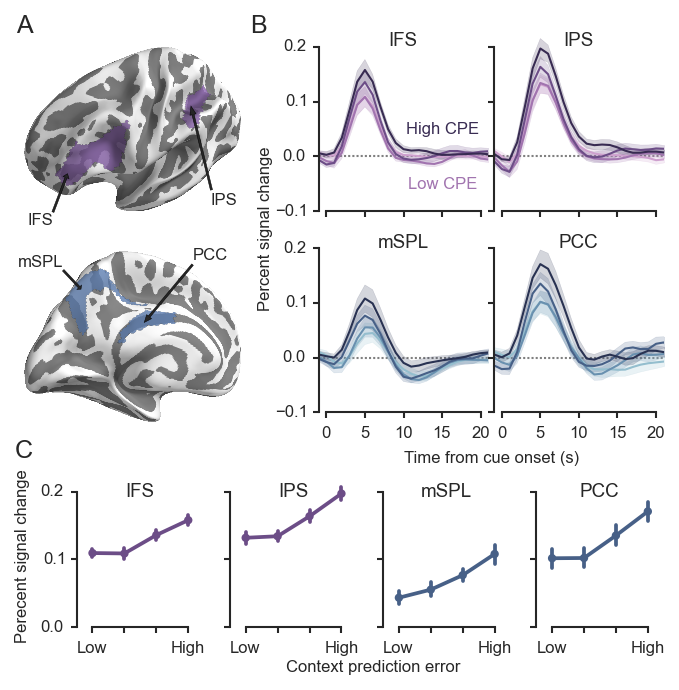

In [18]:
def draw_cpe_hrfs(cortex, df):
    
    f = plt.figure(figsize=(4.5, 4.5))

    # --------------------------------------------------------------------------
    # Panel A: ROIs on inflated group surface

    roi_grid = plt.GridSpec(3, 3, left=.03, bottom=.05, top=.97, right=1,
                            hspace=0, wspace=0)
    roi_axes = [f.add_subplot(roi_grid[r, 0]) for r in [0, 1]]

    for side, ax in zip(["lat", "med"], roi_axes):
        ax.imshow(cortex.snapshots["lh"][side], rasterized=True)
        ax.set(xticks=[], yticks=[])
        ax.set_axis_off()

    # Add arrows with annotations to label each of the ROIs
    text_kws = dict(size=8, ha="center", va="center")
    text_kws["xycoords"] = "figure fraction"
    text_kws["arrowprops"] = dict(facecolor=".15", width=1,
                                  headwidth=3, frac=.1, shrink=.03)

    roi_axes[0].annotate("IFS", (.10, .75), (.06, .68), **text_kws)
    roi_axes[0].annotate("IPS", (.28, .85), (.33, .71), **text_kws)
    roi_axes[1].annotate("mSPL", (.12, .58), (.06, .62), **text_kws)
    roi_axes[1].annotate("PCC", (.21, .53), (.31, .63), **text_kws)


    # --------------------------------------------------------------------------
    # Panel B: FIR-estimated timecourses across CPE quartiles

    fir_grid = plt.GridSpec(3, 3, wspace=.03, hspace=.05,
                            left=.125, bottom=.1, right=.98, top=.98,
                            width_ratios=[.4, .3, .3])
    fir_axes = [f.add_subplot(fir_grid[r, c]) for r in [0, 1] for c in [1, 2]]
    fir_axes = np.array(fir_axes, np.object).reshape(2, 2)

    for i, side in enumerate(["lat", "med"]):
        palette = palettes[side]
        for j, roi in enumerate(networks[side]):
            ax = fir_axes[i, j]
            mask = "yeo17_" + roi.lower()
            roi_df = df.query("condition != 'error' and roi == '{}'".format(mask))
            roi_df = roi_df.sort("condition")
            sns.tsplot(roi_df, "timepoint", "subj", "condition", "coef",
                       color=palette, n_boot=10000, legend=False, ax=ax)

            # Add supporting plot details
            ax.axhline(0, ls=":", c=".5", zorder=0, dashes=[1, 1])
            ax.text(10, .21, roi, size=9, ha="center", va="center")
            ax.set(xlabel="", ylabel="", xlim=(-1, 21),
                   yticks=[-.1, 0, .1, .2], ylim=(-.1, .25))

            # Don't show ticklabels on interior axes
            if i == 0:
                ax.set_xticklabels([])
            if j == 1:
                ax.set_yticklabels([])
            sns.despine(ax=ax, trim=True)

    # Add a key for the CPE levels
    text_kws = dict(size=8, ha="center")
    fir_axes[0, 0].text(15, -.06, "Low CPE", color=palettes["lat"][1], **text_kws)
    fir_axes[0, 0].text(15, .04, "High CPE", color=palettes["lat"][3], **text_kws)

    # Add axes labels that are shared across sub-panels
    text_kws = dict(size=8, ha="center", va="center")
    f.text(.724, .33, "Time from cue onset (s)", **text_kws)
    f.text(.39, .67, "Percent signal change", rotation=90, **text_kws)


    # -----------------------------------------------------------------------------
    # Panel C: Percent signal change at HRF peak

    # Set up the axes
    peak_grid = plt.GridSpec(3, 4, height_ratios=[.36, .36, .26],
                             left=.11, bottom=.08, right=.98, top=.98)
    peak_axes = [f.add_subplot(peak_grid[-1, c]) for c in range(4)]

    for i, (roi, ax) in enumerate(zip(rois, peak_axes)):

        # Pull out the data for this ROI
        mask = "yeo17_" + roi.lower()
        peak_df = df.query(("condition != 'error' "
                            "and timepoint == 5 "
                            "and roi == '{}'".format(mask)))
        peak_df = moss.remove_unit_variance(peak_df, "coef", "subj")

        # Draw as a pointplot
        color = purple if i < 2 else blue
        sns.pointplot("condition", "coef_within", data=peak_df,
                      order=["cpe_1", "cpe_2", "cpe_3", "cpe_4"],
                      color=color, n_boot=10000, ax=ax)
        ax.collections[0].set_sizes([7])

        # Annotate the axes appropriately
        if i:
            ax.set(yticklabels=[])
        ax.text(1.5, .2, roi, size=9, ha="center", va="center")
        ax.set(xlabel="", xticklabels=["Low", "", "", "High"],
               ylabel="", ylim=(0, .21), yticks=[0, .1, .2])
        sns.despine(ax=ax, trim=True)

    text_kws = dict(size=8, ha="center", va="center")
    f.text(.03, .185, "Perecent signal change", rotation=90, **text_kws)
    f.text(.55, .02, "Context prediction error", **text_kws)

    f.text(.02, .96, "A", size=12)
    f.text(.37, .96, "B", size=12)
    f.text(.02, .33, "C", size=12)

    savefig(f, "hrfs_cpe")
draw_cpe_hrfs(cortex, cpe_quartiles_df)

---

In [19]:
rois = ["IFS", "IPS", "mSPL", "PCC"]
masks = ["yeo17_" + r.lower() for r in rois]
cpe_cuestim_df = estimate_roi_firs(masks, "cpe_cuestim")
cpe_cuestim_df.to_csv("data/cpe_cuestim_fir.csv", index=False)
cpe_cuestim_quartiles_df = estimate_roi_firs(masks, "cpe_cuestim_quartiles")
cpe_cuestim_quartiles_df.to_csv("data/cpe_cuestim_quartiles_fir.csv", index=False)

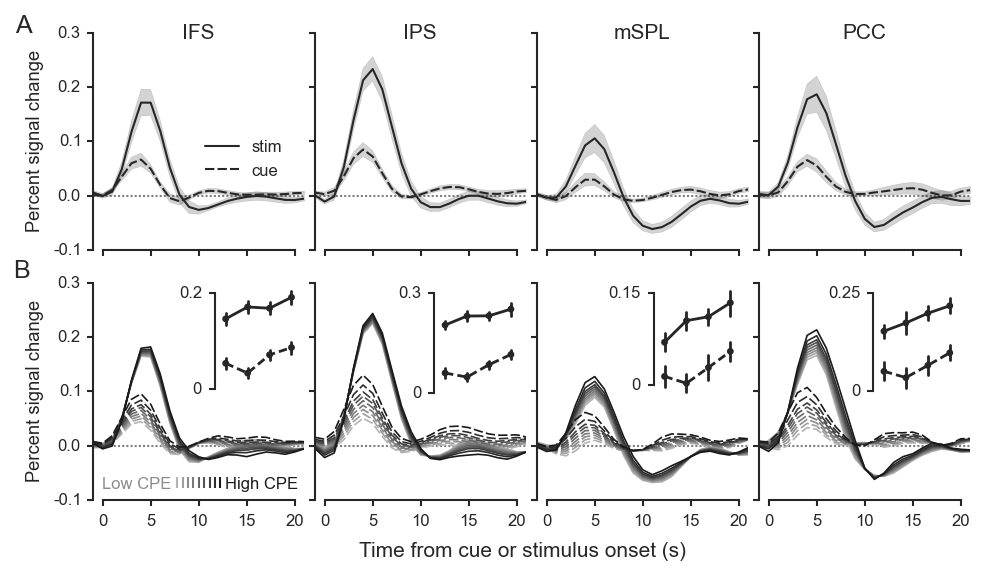

In [20]:
def draw_cue_stim_hrfs(model_df, quart_df):

    # Initialize the figure
    f, axes = plt.subplots(2, 4, figsize=(6.5, 3.8))

    # Colors we will use for the traces
    #colors = [purple, purple, blue, blue]
    colors = [".15"] * 4
    
    # Dash parameters for cue traces
    cue_dashes = [4.5, 1.5]

    # ---------------------------------------------------------------------------
    # Panel A: average evoked BOLD response for cue and stimulus events

    for i, ax, roi in zip(range(4), axes[0], rois):

        # Get the data for this ROI
        mask = "yeo17_" + roi.lower()
        roi_df = model_df.query("roi == @mask")

        # Plot the stimulus-evoked timecourse
        sns.tsplot(roi_df.query("condition == 'stim'"),
                   "timepoint", "subj", "condition", "coef",
                   color=colors[i], ax=ax)

        # Plot the cue-evoked timecourse
        sns.tsplot(roi_df.query("condition == 'cue'"),
                   "timepoint", "subj", "condition", "coef", n_boot=10000,
                   color=colors[i], ls="--", dashes=cue_dashes, ax=ax)

        # Add a constant line at 0
        ax.axhline(0, ls=":", c=".5", zorder=0, dashes=[1, 1], lw=1)

        # Tweak the other plot details
        ax.set(xlim=(-1, 21), ylim=(-.1, .3),
               xlabel="",
               xticklabels=[],
               yticks=[-.1, 0, .1, .2, .3],
               yticklabels=[] if i else [-.1, .0, .1, .2, .3])
        ax.set_ylabel("" if i else "Percent signal change")
        ax.text(10, .3, roi, ha="center", va="center")

        # Label the lines for the first facet
        if not i:
            ax.legend(loc=(.5,  .3))
        else:
            ax.get_legend().remove()

    # ---------------------------------------------------------------------------
    # Panel B: time resolved CPE model for cue and stimulus events
    
    # Set up the quantiles we're going to predict responses for
    n = 9
    quantiles = quantiles = np.percentile(cpe_z, np.linspace(5, 95, n))
    x = np.arange(-1, 23)
    #palettes = dict(blue=sns.cubehelix_palette(n, rot=-.2, light=.75, dark=.25),
    #                purple=sns.cubehelix_palette(n, rot=.2, light=.75, dark=.25))
    l = np.linspace(.3, .9, n)
    palettes = dict(blue=mpl.cm.gray_r(l), purple=mpl.cm.gray_r(l))

    # Loop over the four horizontal facets
    for i, (roi, ax, color) in enumerate(zip(["ifs", "ips", "mspl", "pcc"],
                                         axes[1],
                                        ["purple", "purple", "blue", "blue"])):

        # Pull out the data for this ROI
        mask = "yeo17_" + roi
        roi_df = (model_df.query("roi == @mask")
                          .groupby(["condition", "timepoint"])
                          .mean()
                          .unstack())

        # Get the list of colors for these traces
        colors = palettes[color]

        # Draw traces for cue and stim data at each quantile
        for q, c in zip(quantiles, colors):
            kws = dict(lw=.8, c=c)
            for cond in ["stim", "cue"]:
                ax.plot(x, roi_df.ix[cond] + roi_df.ix["cpe_" + cond] * q, **kws)

                # Update kwargs so the second plot will be dashes
                kws["dashes"] = cue_dashes

        # Add a constant line at 0
        ax.axhline(0, ls=":", c=".5", zorder=0, dashes=[1, 1])

        # Set the axes details
        ax.set(xlim=(-1, 21), ylim=(-.1, .3), xlabel="",
               yticks=[-.1, 0, .1, .2, .3],
               yticklabels=[] if i else [-.1, .0, .1, .2, .3])
        ax.set_ylabel("" if i else "Percent signal change")


    # Add legend information
    ax = axes[1, 0]
    kws= dict(size=8, ha="center", va="center")
    ax.text(3.5, -.07, "Low CPE", color=palettes["purple"][2], **kws)
    ax.text(16.5, -.07, "High CPE", color=palettes["purple"][-1], **kws)
    for q, c in zip(np.linspace(7.75, 12.25, 9), palettes["purple"]):
        ax.vlines(q, -.0775, -.0575, color=c)

    sns.despine(trim=True)

    # ---------------------------------------------------------------------------
    # Insets to panel B showing peak signal change within CPE quartiles

    # Set up the inset axes
    inset_grid = plt.GridSpec(1, 8, .09, .30, .98, .51, .1,
                              width_ratios=[.14, .11] * 4)
    with plt.rc_context({"xtick.major.size": 0}):
        inset_axes = [f.add_subplot(inset_grid[i]) for i in range(1, 8, 2)]

    # Split the condition variable to get stim/cue and cpe variables
    quart_df = quart_df.query("condition != 'error'")
    quart_df.loc[:, "component"] = quart_df["condition"].str[:-6]
    quart_df.loc[:, "quartile"] = quart_df["condition"].str[-1].astype(int)

    # Loop over the four horizontal facets
    limits = [(0, .2), (0, .3), (0, .15), (0, .25)]
    for i, (roi, ax, lim, color) in enumerate(zip(["ifs", "ips", "mspl", "pcc"],
                                                  inset_axes, limits,
                                                  [".15"] * 4)):

        mask = "yeo17_" + roi.lower()
        for comp in ["stim", "cue"]:

            # Pull out the data for the peak timepoint from this ROI/event
            peak = 4 if comp == "cue" else 5
            peak_df = (quart_df.query(("roi == @mask "
                                       "and component == @comp "
                                       "and timepoint == @peak")))
            peak_df = moss.remove_unit_variance(peak_df, "coef", "subj")

            # Draw the quartiles using a pointplot
            sns.pointplot("quartile", "coef_within", data=peak_df,
                          scale=.75, n_boot=10000,
                          order=range(1, 5), color=color, ax=ax)

            # Tweak the aesthetics of the main part of the plot
            ax.collections[-1].set_sizes([5])
            if comp == "cue":
                # Make the joining line (but not CIs)
                ax.lines[5].set_dashes([4, 2])

        # Set the rest of the plot aesthetics
        ax.set(xlabel="",
               ylabel="",
               ylim=(lim[0] - .03, lim[1] * 1.1),
               yticks=lim,
               yticklabels=lim,
               xticklabels=[]) 
        sns.despine(ax=ax, bottom=True, trim=True)
    
    # ---------------------------------------------------------------------------
    
    # Add a label for the x axes
    f.text(.53, .03, "Time from cue or stimulus onset (s)", ha="center")

    # Add figure panel labels
    f.text(.01, .95, "A", size=12)
    f.text(.01, .52, "B", size=12)

    # Finalize and save
    f.subplots_adjust(.09, .13, .99, .95, .05, .15)
    savefig(f, "hrfs_cue_stim")
draw_cue_stim_hrfs(cpe_cuestim_df, cpe_cuestim_quartiles_df)

----

In [21]:
network_cortex = SurfacePlotter("cpe_main", "cpe", show_mask=False)
network_cortex.add_rois(["yeo17_fpn", "yeo17_con", "yeo17_dan"],
                        [purple, red, brown])
network_cortex.save_views(["lat", "ins", "med"])
network_cortex.close()

In [22]:
network_coef_df = extract_cope_data(["yeo17_fpn", "yeo17_con", "yeo17_dan"],
                                     "cpe_main", ["cpe", "error", "response_time"])
network_coef_df = moss.remove_unit_variance(network_coef_df, "cope", "subj", "param")

In [23]:
network_coef_df.to_csv("data/network_coefs.csv", index=False)

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/seaborn/categorical.py:2653: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)


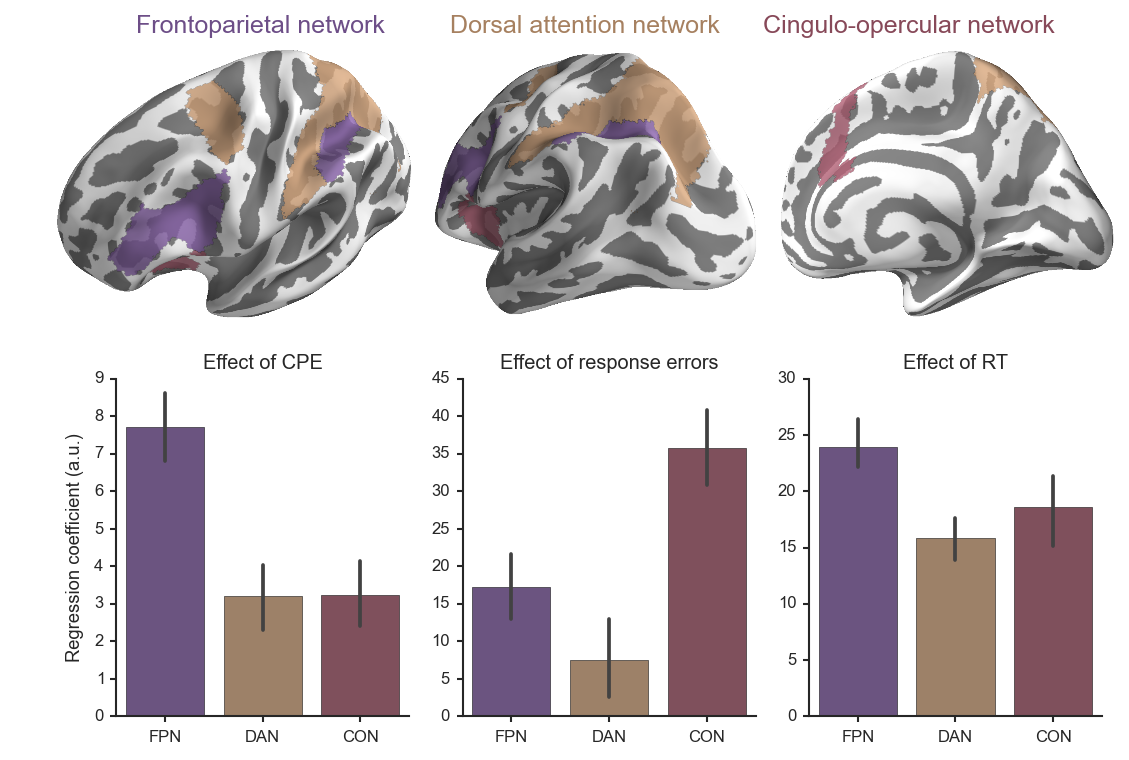

In [24]:
def plot_network_params(cortex, df):

    # Draw a faceted barplot
    g = sns.factorplot("roi", "cope_within", col="param", data=df,
                       size=3, aspect=.8, sharey=False, n_boot=100000,
                       x_order=["yeo17_fpn", "yeo17_dan", "yeo17_con"],
                       palette=[purple, brown, red], kind="bar")

    # Label the plots
    g.set_axis_labels("", "Regression coefficient (a.u.)")
    g.set(xticklabels=["FPN", "DAN", "CON"])
    titles = ["Effect of CPE", "Effect of response errors", "Effect of RT"]
    for ax, param in zip(g.axes.flat, titles):
        ax.set_title(param)

    # Now strech the figure so there is space for the brains
    f = g.fig
    f.set_figheight(5)
    f.subplots_adjust(bottom=.05, top=.5)

    # Plot the cortex views to show the network definitions
    # ----------------------------------------------------------
    lat_ax = f.add_axes([.01, .56, .33, .4])
    lat_ax.imshow(cortex.snapshots["lh"]["lat"], rasterized=True)
    lat_ax.set_axis_off()

    ins_ax = f.add_axes([.36, .57, .30, .38])
    ins_ax.imshow(cortex.snapshots["lh"]["ins"], rasterized=True)
    ins_ax.set_axis_off()

    med_ax = f.add_axes([.68, .56, .31, .4])
    med_ax.imshow(cortex.snapshots["rh"]["med"], rasterized=True)
    med_ax.set_axis_off()

    # Add labels for the three networks
    f.text(.20, .97, "Frontoparietal network", size=12, color=purple, ha="center", va="center")
    f.text(.50, .97, "Dorsal attention network", size=12, color=brown, ha="center", va="center")
    f.text(.80, .97, "Cingulo-opercular network", size=12, color=red, ha="center", va="center")

    savefig(f, "network_params")
plot_network_params(network_cortex, network_coef_df)

In [25]:
groupby_ttest(network_coef_df, "cope", ["roi", "param"]).astype(object)

mean     t         p
roi       param                              
yeo17_con cpe            3.24   3.2   0.00645
          error          35.9  7.14  4.99e-06
          response_time  18.6  8.34  8.46e-07
yeo17_dan cpe             3.2  2.54    0.0235
          error          7.57  1.46     0.165
          response_time  15.8   5.3  0.000113
yeo17_fpn cpe            7.72  6.51  1.38e-05
          error          17.2  2.85    0.0129
          response_time  23.9  6.54   1.3e-05

In [26]:
moss.df_ttest(network_coef_df.query("param == 'cpe' and roi != 'yeo17_dan'"),
              by="roi", key="cope", paired=True)

't(14) = -5.510; p = 7.68e-05***'

In [27]:
moss.df_ttest(network_coef_df.query("param == 'cpe' and roi != 'yeo17_con'"),
              by="roi", key="cope", paired=True)

't(14) = -5.519; p = 7.56e-05***'

In [28]:
moss.df_ttest(network_coef_df.query("param == 'error' and roi != 'yeo17_dan'"),
              by="roi", key="cope", paired=True)

't(14) = 4.523; p = 0.000478***'

----